In [131]:
import numpy as np 
import os 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
from myheatmap import myheatmap

import matplotlib
print(matplotlib.__version__) # version 3 required for cmap='twilight_shifted'

sns.set_context('poster') # makes text larger

add_circle = False



3.1.2


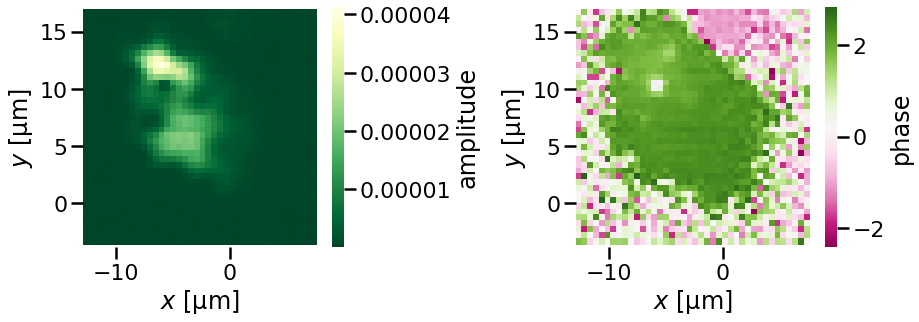

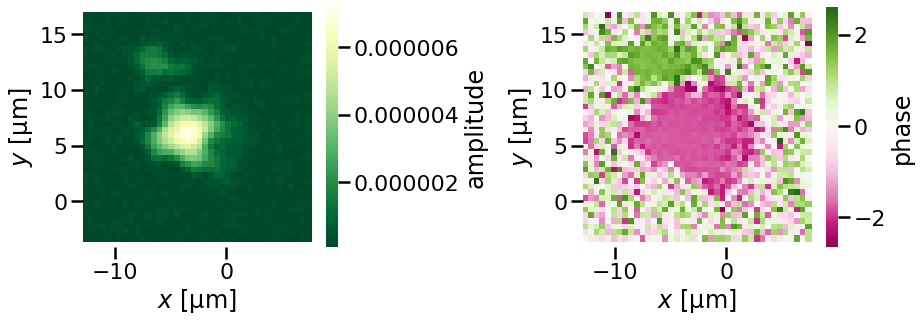

In [132]:
############### Mac vs Windows ##############
folder = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/2019/2019/08/09/'
#folder = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample2\2019\2019\08\09'


file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum_15.16MHz_1104325' 
path = os.path.join(folder,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df) 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13.23,5))

#plt.suptitle(file + '\n\n');

plt.sca(ax1)
df['X um']=df['Green X']
df['Y um']= df['Green Y']
amp1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
myheatmap(amp1, 'amplitude', cmap = 'YlGn_r');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax1.axis('equal')


plt.sca(ax2) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']
phase1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
myheatmap(phase1, 'phase', cmap='PiYG');
ax2.axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.tight_layout();


file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum1_15.5MHz105133' 
path = os.path.join(folder,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df) 


fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(13.23,5))

plt.sca(ax3)
df['X um']=df['Green X']
df['Y um']= df['Green Y']
amp2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
myheatmap(amp2, 'amplitude', cmap = 'YlGn_r');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax3.axis('equal');

if add_circle:
    circle1 = plt.Circle((-6.8, 7.6), 1, color='w', alpha = .3)
    circle2 = plt.Circle((-2.9,9.9), 1, color='w', alpha = .3)
    circle3 = plt.Circle((-1,5), 1, color='w', alpha = .3)
    ax3.add_artist(circle1)
    ax3.add_artist(circle2)
    ax3.add_artist(circle3)

plt.sca(ax4) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']
phase2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
myheatmap(phase2, 'phase', cmap='PiYG');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax4.axis('equal');

plt.tight_layout();

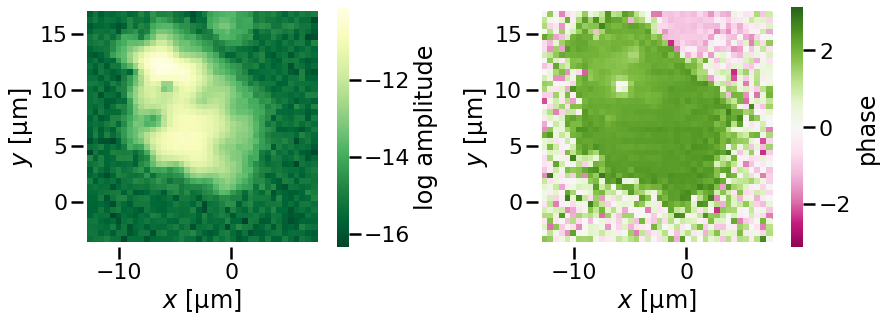

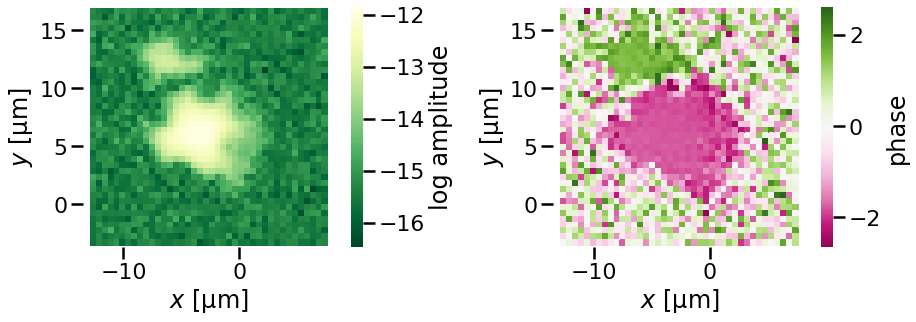

In [133]:
file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum_15.16MHz_1104325' 
path = os.path.join(folder,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df) 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8,5))

#plt.suptitle(file + '\n\n');

plt.sca(ax1) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']
amp1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
myheatmap(np.log(amp1), 'log amplitude', cmap = 'YlGn_r');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax1.axis('equal')


plt.sca(ax2) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']
phase1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
myheatmap(phase1, 'phase', vmin=-np.pi, vmax = np.pi, cmap='PiYG');
ax2.axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.tight_layout();


file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum1_15.5MHz105133' 
path = os.path.join(folder,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df) 


fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(13.23,5))

plt.sca(ax3)
df['X um']=df['Green X']
df['Y um']= df['Green Y']
amp2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
myheatmap(np.log(amp2), 'log amplitude', cmap = 'YlGn_r');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax3.axis('equal');

if add_circle:
    circle1 = plt.Circle((-6.8, 7.6), 1, color='w', alpha = .3)
    circle2 = plt.Circle((-2.9,9.9), 1, color='w', alpha = .3)
    circle3 = plt.Circle((-1,5), 1, color='w', alpha = .3)
    ax3.add_artist(circle1)
    ax3.add_artist(circle2)
    ax3.add_artist(circle3)

plt.sca(ax4)
df['X um']=df['Green X']
df['Y um']= df['Green Y']
phase2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
myheatmap(phase2, 'phase', cmap='PiYG');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax4.axis('equal');

plt.tight_layout();

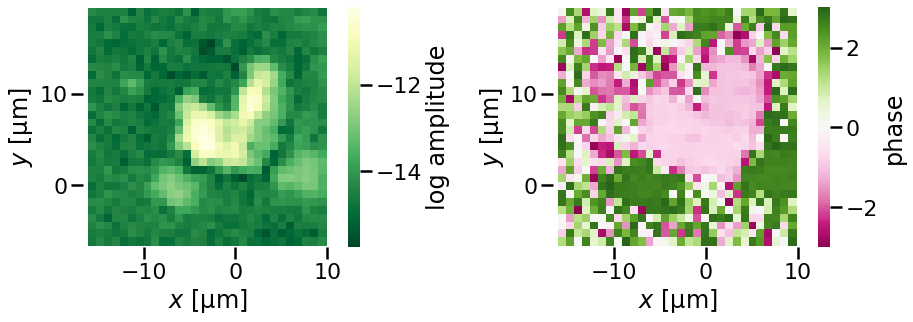

In [134]:
folder = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/2019/07/30/'
file = 'PosGU01Arrray01.00r0.5p3Device0.1Drum2_10V114238' 
path = os.path.join(folder,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df) 

fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(13.23,5))

#plt.suptitle(file + '\n\n');

plt.sca(ax1)
df['X um']=df['Green X']
df['Y um']= df['Green Y']
amp1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
myheatmap(np.log(amp1), 'log amplitude', cmap = 'YlGn_r');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax1.axis('equal')


plt.sca(ax2) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']
phase1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
myheatmap(phase1, 'phase', cmap='PiYG');
ax2.axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.tight_layout();

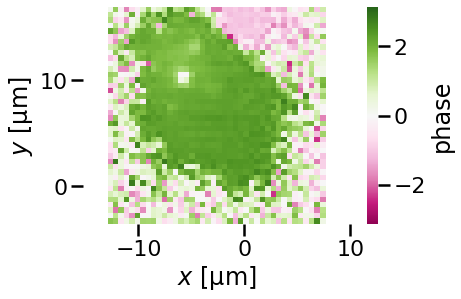

In [129]:
myheatmap(phase1, 'phase', 
          vmin=-np.pi, 
          vmax = np.pi, 
          cmap='PiYG');
plt.gca().axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]');

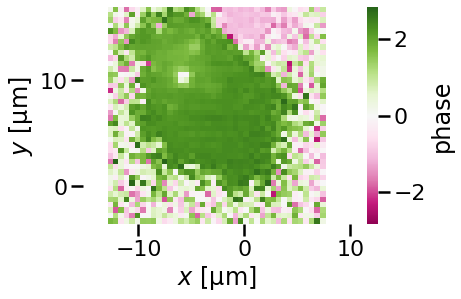

In [130]:
myheatmap(phase1, 'phase', 
          vmin=-max(-np.array(phase1).min(),np.array(phase1).max()), 
          vmax = max(-np.array(phase1).min(),np.array(phase1).max()), 
          cmap='PiYG');
plt.gca().axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]');

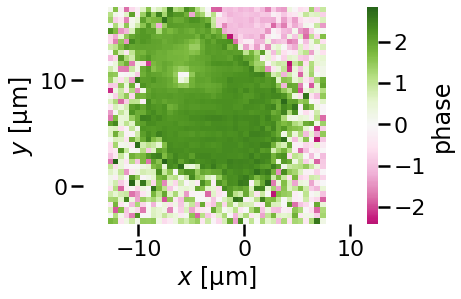

In [53]:
import matplotlib as mpl
import scipy as sp


# source: https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return sp.ma.masked_array(sp.interp(value, x, y))
    
# set midpoint at zero.
vmin = np.array(phase1).min()
vmax = np.array(phase1).max()
norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)


## Plot with a norm at 0
myheatmap(phase1, 'phase', norm = norm,
          cmap='PiYG');
plt.gca().axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]');

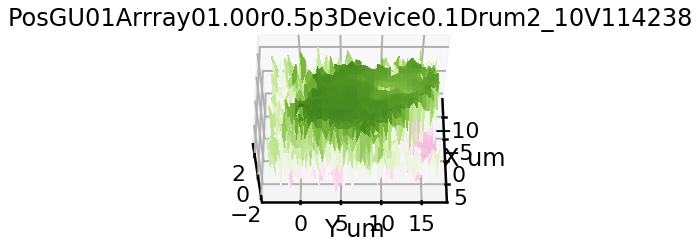

In [109]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
X, Y = np.meshgrid(phase1.columns,phase1.index )
ax.plot_surface(X,Y,phase1, 
                norm=norm,  # set midpoint at 0.
                antialiased=False,
                cmap='PiYG', )
plt.xlabel(phase1.columns.name)
plt.ylabel(phase1.index.name)
ax.set_title(file);
ax.view_init(elev=60., azim=0)

/Users/brittanycarter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


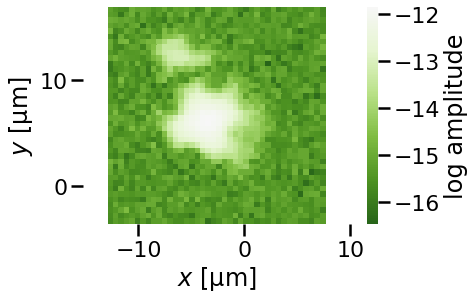

In [126]:
## Cut colorbar in half.

data = np.log(amp1)

# set white at max.
vmin = np.array(data).min()
vmax = np.array(data).max()
norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)


## Plot with a midpoint at 0.
myheatmap(data, 'log amplitude', norm = norm,
          cmap='PiYG_r');
plt.gca().axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]');

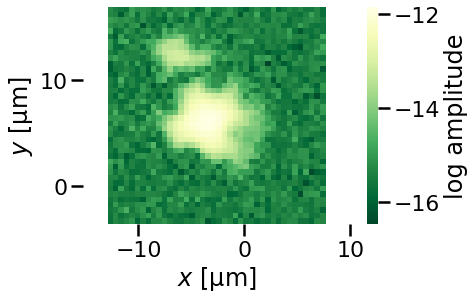

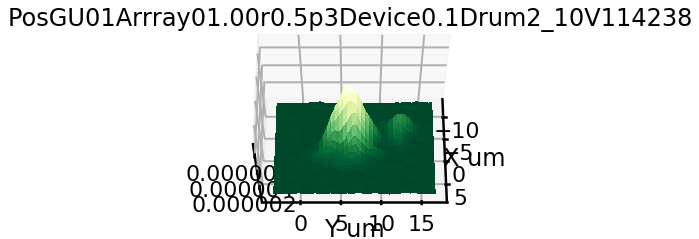

In [118]:
myheatmap(np.log(amp1), 'log amplitude', cmap = 'YlGn_r');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

plt.figure()
ax = plt.axes(projection='3d')
X, Y = np.meshgrid(amp1.columns,amp1.index )
ax.plot_surface(X,Y,(amp1), 
                antialiased=False,
                cmap='YlGn_r', )
plt.xlabel(amp1.columns.name)
plt.ylabel(amp1.index.name)
ax.set_title(file);
ax.view_init(elev=60., azim=0)

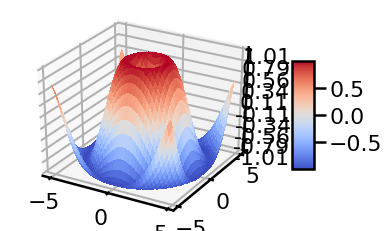

In [74]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [76]:
X

array([[-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
       [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
       [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
       ...,
       [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
       [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
       [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75]])